In [1]:
import random
from tqdm import tqdm_notebook, tqdm
tqdm_notebook().pandas()
import pickle
import numpy as np 
import pandas as pd
# from pandarallel import pandarallel # for linux and mac
# pandarallel.initialize()
from sklearn.model_selection import train_test_split
from utils import *
# import shared_vars


Vars loaded!


In [3]:
shared_vars.exp.head(1)

,idteam,idtournament,players,q_taken,q_numb,q_id
0,209,3236,"[5974, 7474, 13601, 15624, 19298, 32017]",1,0,3236000


## Train test split

In [4]:
train, test = train_test_split(shared_vars.exp, test_size=0.3, random_state=42)

## Players skills and question difficulties as numpy arrays
https://stackoverflow.com/questions/36652533/looking-up-large-sets-of-keys-dictionary-vs-numpy-array

## Learning

**Model**<br>
$p(y=1| S_{team}, \theta) = \sigma(S_{team} - \theta)$ <br>
$S_{team}$ - team skill<br>
$S_{team} = S_{player\_1} + S_{player\_2} + ... + S_{player\_N}$<br>
$\theta_j$ - difficulty of question j<br>
y - team answer, 1 for correct, 2 for incorrect<br>
$p(y_{hat}=y_{real}| S_{team}, \theta) = \sigma(S_{team} - \theta)^{y_{real}} * (1-\sigma(S_{team} - \theta))^{(1-y_{real})}$<br>
<br>
$LikelyHood = \frac{1}{N}\prod_{i=1}^{N} p(y_{hat\_i}=y_{real\_i}| S_{team}, \theta)$<br>
$log(LikelyHood) = LL = \frac{1}{N}\sum_{i=1}^{N} log(p(y_{hat\_i}=y_{real\_i}| S_{team}, \theta))=
y_{real}*log(\sigma(S_{team} - \theta)) + (1-y_{real})* log(1-\sigma(S_{team} - \theta))$<br>
<br>
$-log(LikelyHood) \rightarrow min$ w.r.t. $S_{player\_i}$ and $\theta_j$

**Derivatives:**

$\sigma'(x) = \sigma(x)*(1-\sigma(x))$

$\frac{\partial LL}{\partial \theta} = \frac{y_{real}}{\sigma(S_{team} - \theta)} * \sigma'(S_{team} - \theta) * (-1) +
\frac{1-y_{real}}{1-\sigma(S_{team} - \theta)} * (-\sigma'(S_{team} - \theta)) * (-1) = 
-y_{real}*(1-\sigma(S_{team} - \theta)) + (1-y_{real})*\sigma(S_{team} - \theta)
$<br>

$\frac{\partial LL}{\partial S_i} = \frac{y_{real}}{\sigma(S_{team} - \theta)} * \sigma'(S_{team} - \theta) +
\frac{1-y_{real}}{1-\sigma(S_{team} - \theta)} * (-\sigma'(S_{team} - \theta)) = 
y_{real}*(1-\sigma(S_{team} - \theta)) - (1-y_{real})*\sigma(S_{team} - \theta)$<br>


**Short derivatives:**

$\frac{\partial -LL}{\partial \theta} = +y_{real}*(1-\sigma(S_{team} - \theta)) - (1-y_{real})*\sigma(S_{team} - \theta)
$<br>

$\frac{\partial -LL}{\partial S_i} = -y_{real}*(1-\sigma(S_{team} - \theta)) + (1-y_{real})*\sigma(S_{team} - \theta)$<br>


**Gradient update**<br>
$S_{i\_new} = S_{i\_old} - learning\_rate * \frac{\partial LL}{\partial S_i}$<br>
$\theta_{new} = \theta_{old} - learning\_rate * \frac{\partial LL}{\partial \theta}$<br>

In [8]:
%%timeit -n1 -r1
sgd(df = train, lr=0.5, epochs=200, batch_size=5000)
sgd(df = train, lr=0.5, epochs=200, batch_size=5000)
sgd(df = train, lr=0.5, epochs=200, batch_size=5000)


8min 33s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [ ]:
from multiprocessing import Pool
from functools import partial

In [26]:
df1 = shared_vars.difficulties.copy()

In [27]:
processes = 3
if __name__ ==  '__main__':
    num_processors = 3
    p=Pool(processes = num_processors)
    sgd_part = partial(sgd, df=train, epochs=20, batch_size=5000)
    p.map(sgd_part,[0.3]*processes)
 

In [ ]:
shared_vars.difficulties == df1

In [10]:
def add_model_prob(df):
    df.loc[:, 't_sigm'] = df.progress_apply(lambda row: sigmoid(team_performance(row['players']) -
                                                                get_difficulties_by_q_id(row['q_id']) ), axis=1)
    return df

In [23]:
train = add_model_prob(train).copy(deep=True)

In [12]:
def calculate_loss(df):
    df.loc[:, 'one_loss'] = df['q_taken']*np.log(df['t_sigm']) + (1-df['q_taken'])*np.log(1-df['t_sigm'])
    total_loss = -df['one_loss'].sum()
    print(total_loss)

In [24]:
calculate_loss(train)

3542555.7185248444


3542555.7185248444


## ROC AUC

In [14]:
test = add_model_prob(test)

In [15]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

In [16]:
roc_auc_score(test.q_taken, test.t_sigm)

0.817588161125707

In [17]:
import matplotlib.pyplot as plt
fpr, tpr, thresholds = roc_curve(test.q_taken, test.t_sigm)
roc_auc = auc(fpr, tpr)

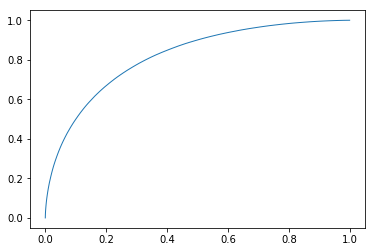

In [18]:
plt.plot(fpr, tpr, lw=1, alpha=1)

## Exploit

In [ ]:
def at_least_same_taken_prob(probabilities, taken):
    ques_amount = len(probabilities)
    prob_matrix = np.zeros(shape=(ques_amount+1, ques_amount+1))
    prob_matrix[0, 0] = 1
    for i in range(ques_amount+1):
        for j in range(1, ques_amount+1):
            prob_matrix[i, j] = prob_matrix[i, j-1] * (1 - probabilities[j-1]) +\
                                prob_matrix[i-1, j-1] * probabilities[j-1]
    return prob_matrix[taken:, -1].sum()

In [ ]:
result_tr = train.groupby(['idtournament', 'idteam'])\
                 .progress_apply(lambda row: at_least_same_taken_prob(row['t_sigm'].tolist(), row['q_taken'].sum()))\
                 .reset_index()\
                 .rename(columns={0: 'prob'})\
                 .sort_values('prob')\
                 .reset_index(drop=True)

In [ ]:
result_te = test.groupby(['idtournament', 'idteam'])\
                .progress_apply(lambda row: at_least_same_taken_prob(row['t_sigm'].tolist(), row['q_taken'].sum()))\
                .reset_index()\
                .rename(columns={0: 'prob'})\
                .sort_values('prob')\
                .reset_index(drop=True)

In [ ]:
result_tr.head(20)

In [ ]:
# zip(results.loc[results.questions_total == 0, ['idteam', 'idtournament']])
# results.loc[results.questions_total == 0, 'idtournament'].tolist()
res = pd.merge( result, results.loc[results.questions_total != 0, ['idteam', 'idtournament']], on=['idteam', 'idtournament'])

In [ ]:
res.iloc[1000:1010]

In [ ]:
def susp_team_res(team, tour):
    susp_team = results.loc[(results.idteam == team) & (results.idtournament == tour), 'players'].item()
    return results.loc[results.players.astype(str) == str(susp_team), :]

In [ ]:
team = 4967
tour = 4385

In [ ]:
p=0.3
i=0
tmp = res.loc[res.prob > p, :]
tmp = tmp.reset_index(drop=True)

In [ ]:
i += 10
team = tmp.idteam[i]
tour = tmp.idtournament[i]
tmp.prob[i]

In [ ]:
susp_res = susp_team_res(team, tour)
susp_res

In [ ]:
tour

In [ ]:
res.loc[(res.idteam == team) & (res.idtournament == tour), :]

In [ ]:
len(susp_res['mask'].iloc[1])


In [ ]:
results.loc[results.idtournament == tour, :]

In [ ]:
grouped_t_res = exp.loc[exp.idtournament == tour, :]. groupby('idteam').q_taken.apply(lambda x: sum(x) / len(x)).reset_index()

In [ ]:
grouped_t_res.loc[grouped_t_res.idteam == team]

In [ ]:
grouped_t_res.q_taken.mean()

In [ ]:
roster
